## Visualizing the Convolutional Neural Network's filters

A way to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. This can be done with gradient **ascent** in input space : applying gradient descent to the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a random input image. The resulting input image will be one that the chosen filter is maximally responsive to. 

This process is simple: you’ll build a loss function that maximizes the value of a given filter in a given convolution layer, and then you’ll use stochastic gradient descent (it's ascent here) to adjust the values of the input image so as to maximize this activation value

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(500)

In [3]:
%matplotlib inline

In [4]:
print(tf.__version__)
print(np.__version__)

2.0.0
1.18.1


In [5]:
model = tf.keras.applications.vgg16.VGG16(include_top=True, weights="imagenet")

In [6]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
layer_name = 'block3_conv1'
filter_index = 0

In [8]:
partial_model = tf.keras.Model(model.input, model.get_layer(layer_name).output)

In [9]:
partial_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


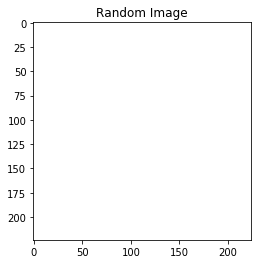

In [10]:
random_image = np.random.random((224, 224, 3)) * 20 + 128
plt.title("Random Image")
plt.imshow(random_image)
plt.show()
random_image = np.expand_dims(random_image, axis=0)  # reshape it to (1,224,224,3),

In [11]:
def get_gradients(model, image, filter_index):
    image_tensor = tf.convert_to_tensor(image, dtype="float32")
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        layer_output = model(image_tensor)
        loss = tf.reduce_mean(layer_output[:, :, :, filter_index])
    grads = tape.gradient(loss, image_tensor)
    return grads

# Normalization Trick
A trick to help the gradient-ascent process go smoothly is to normalize the gradient tensor by dividing it by something very similar to it's L2 norm : **the square root of the average
of the square of the values in the tensor**. This ensures that the magnitude of the updates done to the input image is always within the same range.

In [12]:
step_size = 1
epochs = 30
progbar = tf.keras.utils.Progbar(epochs)
for i in range(epochs):
    grads = get_gradients(partial_model, random_image, filter_index=filter_index)
    grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)  # normalization trick
    random_image += grads * step_size   # + is gradient ascent
    progbar.update(i+1)

30/30 [==============================] - 3s 90ms/step


In [13]:
def deprocess_image(x):
    """Utility function to convert a tensor into a valid image
    """
    x = np.squeeze(x.numpy(), axis=0)
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [14]:
filter_image = deprocess_image(random_image)

In [15]:
filter_image.shape

(224, 224, 3)

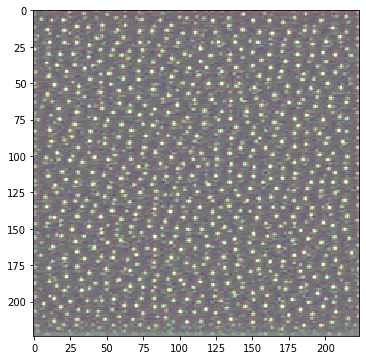

In [16]:
plt.figure(figsize=(6,6))
plt.imshow(filter_image)
plt.show()

Looks like this filter activates when **POLKA DOTS** like patterns are found in the image

In [17]:
def stitch_images(images, margin=5, cols=5):
    """Utility function to stitch images together with a `margin`.
    Args:
        images: The array of 2D images to stitch.
        margin: The black border margin size between images (Default value = 5)
        cols: Max number of image cols. New row is created when number of images exceed the column size.
            (Default value = 5)
    Returns:
        A single numpy image array comprising of input images.
    """
    if len(images) == 0:
        return None

    h, w, c = images[0].shape
    n_rows = int(np.ceil(len(images) / cols))
    n_cols = min(len(images), cols)

    out_w = n_cols * w + (n_cols - 1) * margin
    out_h = n_rows * h + (n_rows - 1) * margin
    stitched_images = np.zeros((out_h, out_w, c), dtype=images[0].dtype)

    for row in range(n_rows):
        for col in range(n_cols):
            img_idx = row * cols + col
            if img_idx >= len(images):
                break

            stitched_images[(h + margin) * row: (h + margin) * row + h,
                            (w + margin) * col: (w + margin) * col + w, :] = images[img_idx]

    return stitched_images

Lets now combine all of the above to a single function. We can use this  function to visualize any layer's any filter

In [18]:
def visualize_single_filter(model, layer_name, filter_index, step_size=1, epochs=30):
    partial_model = tf.keras.Model(model.input, model.get_layer(layer_name).output)
    random_image = np.random.random((224, 224, 3)) * 20 + 128
    random_image = np.expand_dims(random_image, axis=0)  # reshape it to (1,224,224,3),
    for i in range(epochs):
        grads = get_gradients(partial_model, random_image, filter_index=filter_index)
        grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)  # normalization trick
        random_image += grads * step_size   # + is gradient ascent
    return deprocess_image(random_image)

Let's visualize an array of filters. We will visualize only the top 64 filters in a given layer so  that we can fit the 2D stitched image in the notebook

In [19]:
layer_name = 'block1_conv1'
filter_nums = 64
filter_images = []
progbar = tf.keras.utils.Progbar(filter_nums)
for filter_index in range(filter_nums):
    filter_image = visualize_single_filter(model, layer_name, filter_index)
    filter_images.append(filter_image)
    progbar.update(filter_index+1)

64/64 [==============================] - 11s 165ms/step


In [20]:
stitched_image = stitch_images(images=filter_images, margin=5, cols=int(np.sqrt(filter_nums)))

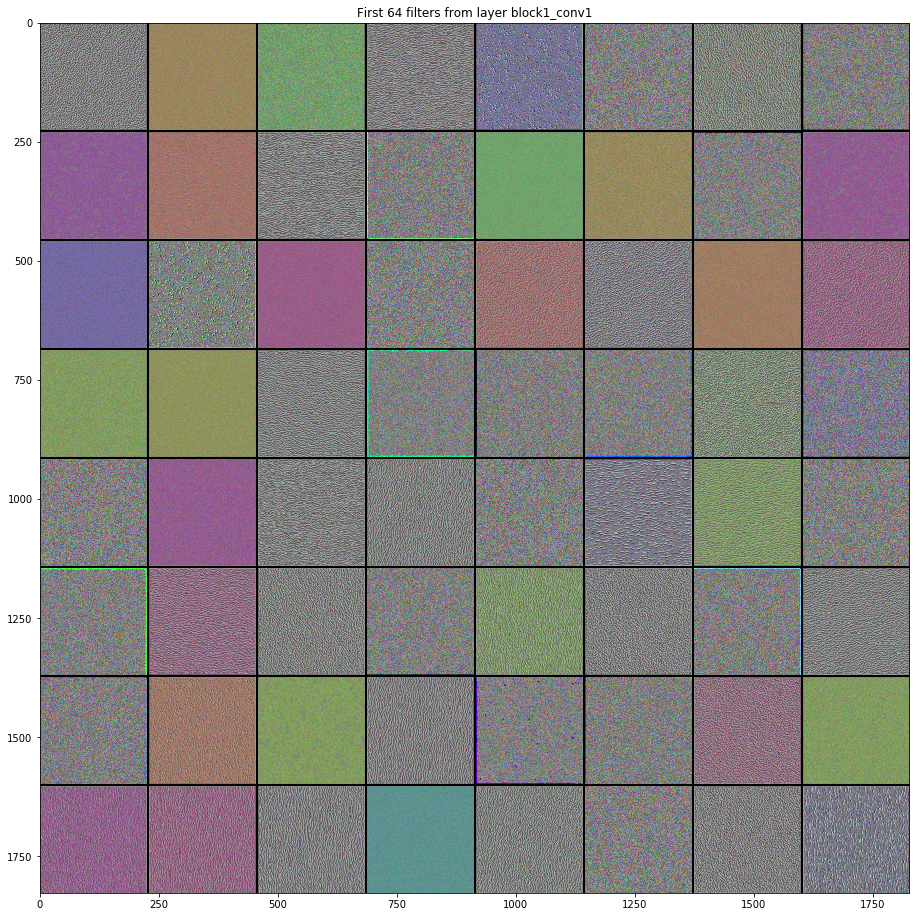

In [21]:
plt.figure(figsize=(16,16))
plt.title("First {} filters from layer {}".format(filter_nums, layer_name))
plt.imshow(stitched_image)
plt.show()

# Inference:

These filter visualizations tell you a lot about how a convolutional neural network sees the world. Each layer in a ConvNet learns a collection of filters such that their inputs can be expressed as a combination of these filters. The filters in these ConvNet layers get increasingly complex and refined as you go higher in the model:

- The filters from the first layer in the model ( block1_conv1 ) encode simple directional edges and colors (or colored edges, in some cases).
- The filters from block2_conv1 encode simple textures made from combinations of edges and colors.
- The filters in higher layers begin to resemble textures found in natural images: feathers, eyes, leaves, and so on.